In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import math

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [4]:
mc_data = pd.read_json('../../datasets/SciFi_200000_Bool_TrackStudy.json')
%store mc_data

Stored 'mc_data' (DataFrame)


In [2]:
mc_data_tmp = pd.read_json('../../datasets/SciFi_200000_Temporal_TrackStudy.json')
%store mc_data_tmp

Stored 'mc_data_tmp' (DataFrame)


In [ ]:
all_hits = pd.read_json('../../datasets/SciFi_200000_AllHits.json')

In [3]:
%store -r mc_data

In [4]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [5]:
mc_hits = mc_data.values

In [6]:
zLays = [7825.99951172, 7895.99951172, 7966.        , 8036.00048828,
       8507.99902344, 8577.99902344, 8647.99902344, 8718.00097656,
       9192.99902344, 9262.99902344, 9332.99902344, 9403.00097656]

max_x = 3182.8356933594
min_x = -3182.8576660156
min_y = -2438.6506347656
max_y = 2438.6506347656

In [7]:
events = np.unique(mc_hits[:,13])
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [21]:
%store zLays
%store max_x
%store min_x
%store max_y
%store min_y
%store events
%store -r notValidParticles

Stored 'zLays' (list)
Stored 'max_x' (float)
Stored 'min_x' (float)
Stored 'max_y' (float)
Stored 'min_y' (float)
Stored 'events' (ndarray)


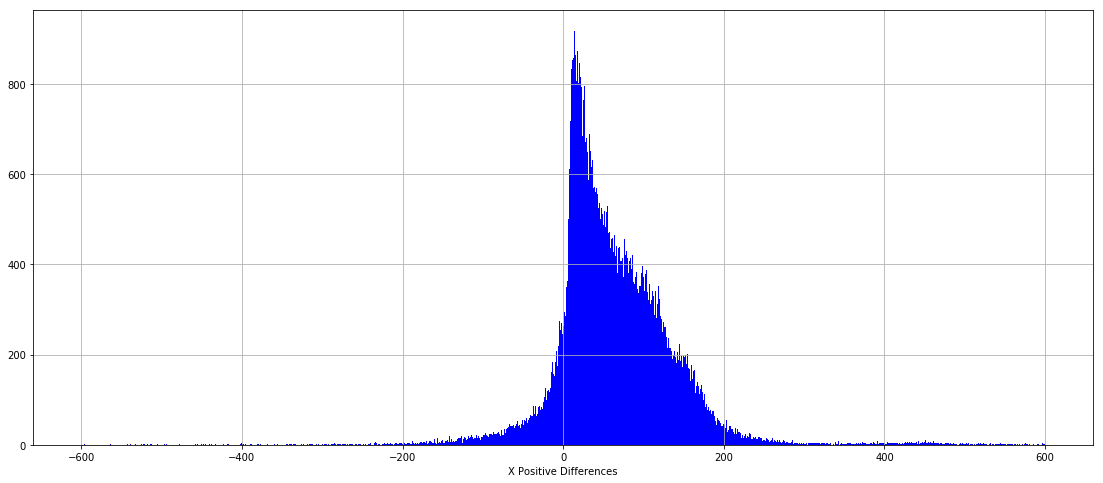

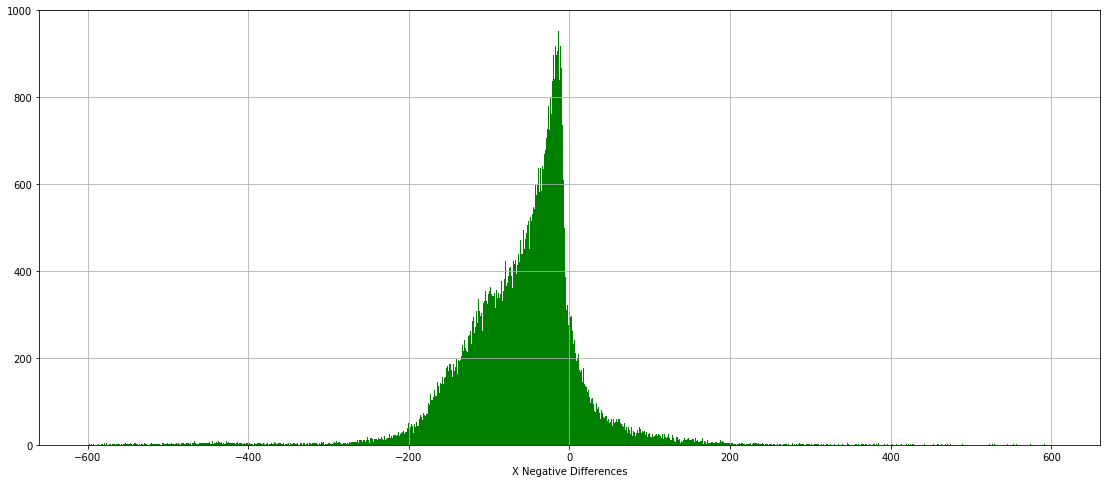

In [8]:

X_plot_positive = []
X_plot_negative = []

for hit in mc_hits:
    
    if (len(hit[5]) > 1):
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
        
        if (X_final[3] == 0):
            continue
        if X_final[0] > 0:
            X_plot_positive.append(X_final[3] - X_final[0])
        else:
            X_plot_negative.append(X_final[3] - X_final[0])

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_positive, 1000, facecolor='blue', range=(-600,600))
ax.set_xlabel('X Positive Differences')
ax.grid()
plt.show()

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_negative, 1000, facecolor='green', range=(-600,600))
ax.set_xlabel('X Negative Differences')
ax.grid()
plt.show()

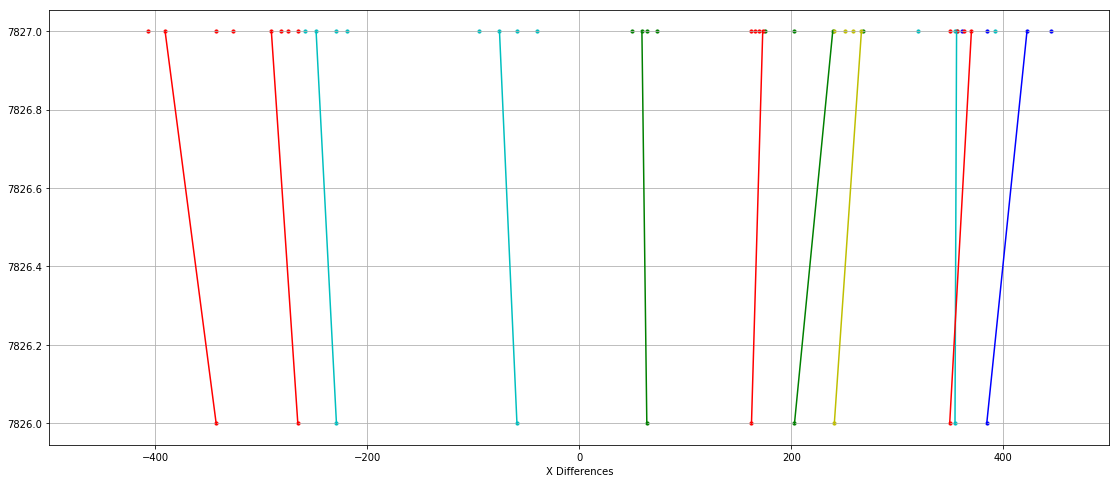

In [9]:

import itertools
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)

X_plot = []
Y_plot = []
color = 0.0

colors = itertools.cycle(["r", "b", "g", "y", "c"])

for hit in mc_hits[mc_hits[:,13] == 15862][:30]:
    
    if (len(hit[5]) > 1):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
        
        if (X_final[1] == 0) or (X_final[2] == 0) or (X_final[3] == 0) or (X_final[4] == 0):
            continue
            
        actual = next(colors)
        ax.scatter([X_final[0], X_final[0], X_final[1],X_final[2],X_final[3]],[zLays[0], zLays[0]+1,zLays[0]+1, zLays[0]+1, zLays[0]+1], s=10, c=actual)
        ax.plot([X_final[0], X_final[3]],[zLays[0],zLays[0]+1], c=actual)
        
ax.set_xlim(-500, 500)
ax.set_xlabel('X Differences')
ax.grid()
plt.show()

In [9]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
        
    if (float(x3 - x0)  == 0):
        m = 1
    else:
        m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [10]:
def histogram(data, color, alphaValue, min, max, title, x_axis, y_axis):
    fig = plt.figure(figsize=(19, 10))
    ax = fig.add_subplot(111)
    
    textstr = '$\mu=%.3f$\n$\sigma=%.3f$\n$n=%.0f$'%(np.mean(np.array(data)), np.std(np.array(data)), len(data))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)

    n, bins, patches = plt.hist(data, 100, facecolor=color, range=(min,max), alpha=alphaValue)
    ax.set_title('%s\n' % title, fontsize=14)
    ax.set_xlabel(x_axis,fontsize=14)
    ax.set_ylabel(y_axis,fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    ax.grid()
    plt.show()

14.982754254303682


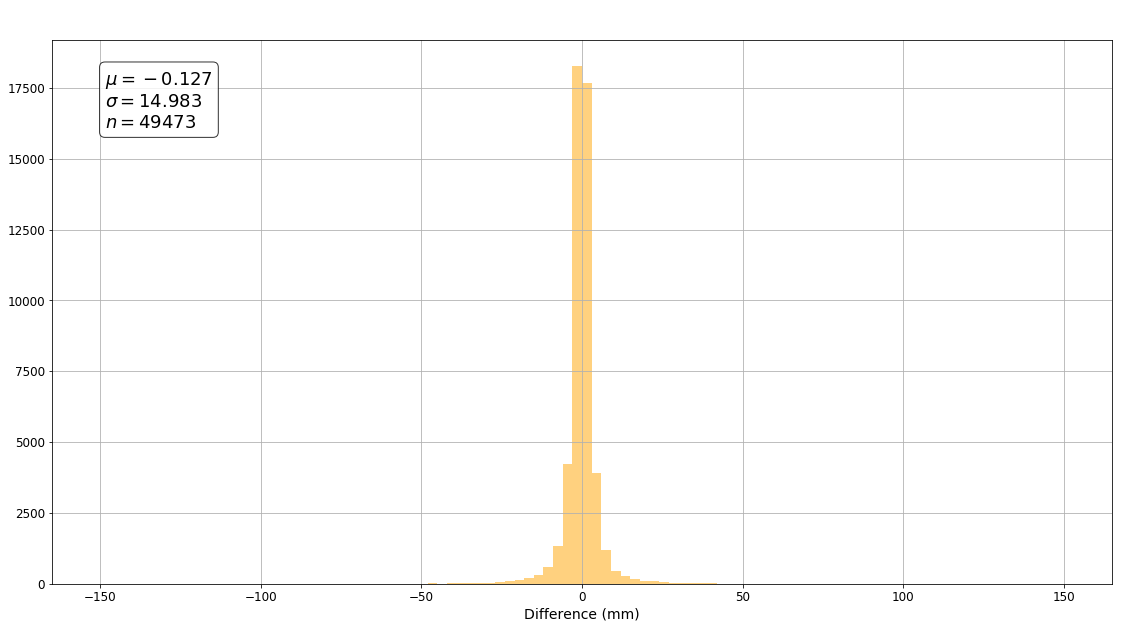

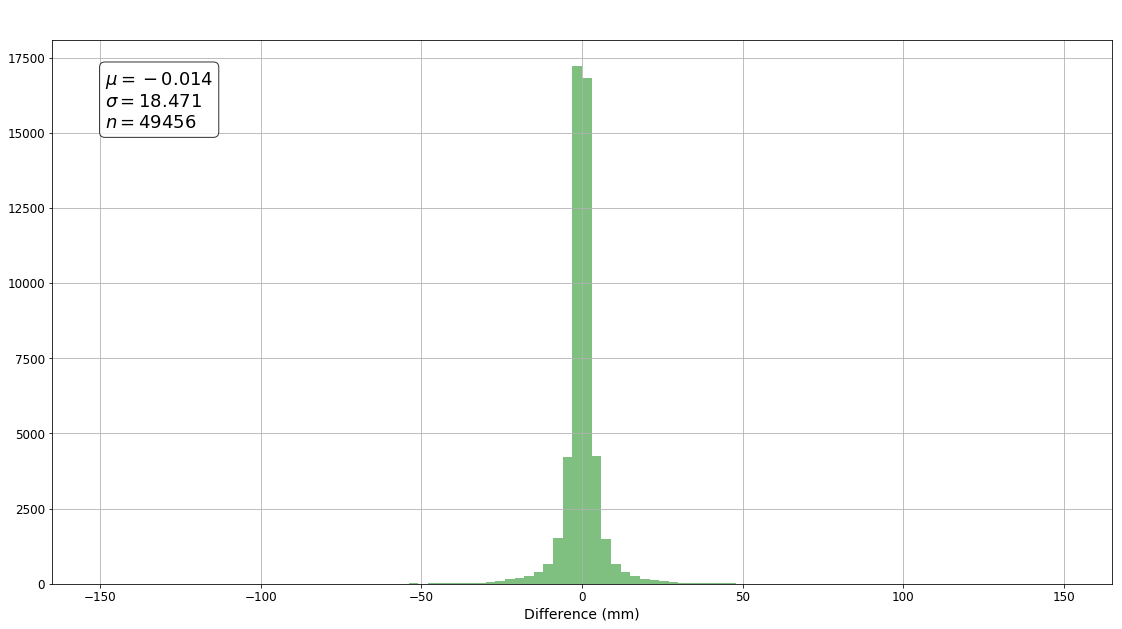

In [19]:
Y_U_plot = []
Y_V_plot = []
Y_X1_plot = []


event_hits = mc_hits[mc_hits[:,13] < events[500]]

# For each particle of a given event
for particle in event_hits:
    
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = {}
        Zone_final = {}
        actual = -1
        found_num = 0

        # Extract all PrHits
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[particle[8][i]] = []
                X_final[particle[8][i]].append(particle[5][i])
                Zone_final[particle[8][i]] = particle[12][i]
                actual = particle[8][i]
                found_num += 1
            else:
                X_final[actual].append(particle[5][i])
                
        if found_num < 12:
            continue
        
        if (X_final[3][0] - X_final[0][0]) == 0:
            continue 
            
        if (X_final[7][0] - X_final[4][0]) == 0:
            continue 
            
        
        pred_h2 = predictHeight(X_final[0][0], X_final[3][0], X_final[1][0], 1, 0, 3)
        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
            continue
        pred_h1 = predictHeight(X_final[0][0], X_final[3][0], X_final[2][0], 2, 0, 3)
        if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
            continue
        mean = (pred_h1 + pred_h2) / 2
        mean_real = (particle[2][1] + particle[2][2]) / 2
        
        Y_U_plot.append(mean_real - mean)

        pred_h2 = predictHeight(X_final[4][0], X_final[7][0], X_final[5][0], 5, 4, 7)
        if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
            continue
        pred_h1 = predictHeight(X_final[4][0], X_final[7][0], X_final[6][0], 6, 4, 7)
        if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
            continue
        mean = (pred_h1 + pred_h2) / 2
        mean_real = (particle[2][5] + particle[2][6]) / 2
        
        Y_V_plot.append(mean_real - mean)
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

print(np.std(Y_U_plot))
histogram(Y_U_plot, 'orange', 0.5, -150, 150, '', 'Difference (mm)', '')
histogram(Y_V_plot, 'green', 0.5, -150, 150, '', 'Difference (mm)', '')
#histogram(Y_X1_plot, 'blue', 0.5, -500, 500, 'Real vs Predicted X in X1 layer', 'Difference (mm)', '')
#histogram(Y_X1_plot, 'red', 0.5, -150, 150, 'X0-U vs X1-V height', 'Difference (mm)', '')

In [35]:
event_hits = []

for event in events[0:100]:
                    
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    total_hits = 0
    for hit in particles_test_event:
        if (len(hit[5]) > 1) and not hit[0] in notValidParticles:     
            for i in range(0,len(hit[4])):
                if i > 0 and np.abs(hit[5][i] - hit[5][i-1]) < 3 and hit[8][i] == hit[8][i-1]:
                    continue
                total_hits += 1
    event_hits.append(total_hits)

In [95]:
def showPlotScatterResultEvents(values, ylabel, color, alpha, label_text, extra):
    plt.figure(figsize=(19, 10))
    plt.plot([np.mean(event_hits), np.mean(event_hits)], [np.min(values) - extra, np.max(values)+ 0.001],'--', c='blue', alpha = 0.4, label='Mean hits per event')
    plt.plot([0, np.max(event_hits)], [np.mean(values), np.mean(values)],'--', c='red', alpha = 0.4, label=label_text)
    plt.scatter(event_hits, values, c=color, marker='^', s=100, alpha=alpha)
    ticks = sorted(list(plt.yticks()[0]), key = lambda p: np.abs(p - np.mean(values)))
    ticks.remove(ticks[0])
    plt.yticks(ticks + [np.mean(values), np.min(values)])
    plt.xticks(list(plt.xticks()[0]) + [np.mean(event_hits)])
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.legend(loc = 'upper right',prop={'size': 16})
    plt.ylim([np.min(values) - extra,np.max(values) + 0.001])
    plt.xlim([0,np.max(event_hits) + 100])
    plt.xlabel('\nNumber of hits in event', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.show()

In [101]:
def showPlotAccuracy(values):
    showPlotScatterResultEvents(values, 'Accuracy\n', 'magenta', 0.5, 'Mean accuracy', 0.02)
def showGhostRate(values):
    showPlotScatterResultEvents(values, 'Ghost rate\n', 'green', 0.5, 'Mean Ghost rate', 0.001)
def showStationAccuracy(values):
    showPlotScatterResultEvents(values, 'Seed reconstruction accuracy\n', 'orange', 0.7, 'Mean seed station reconstruction', 0.01)

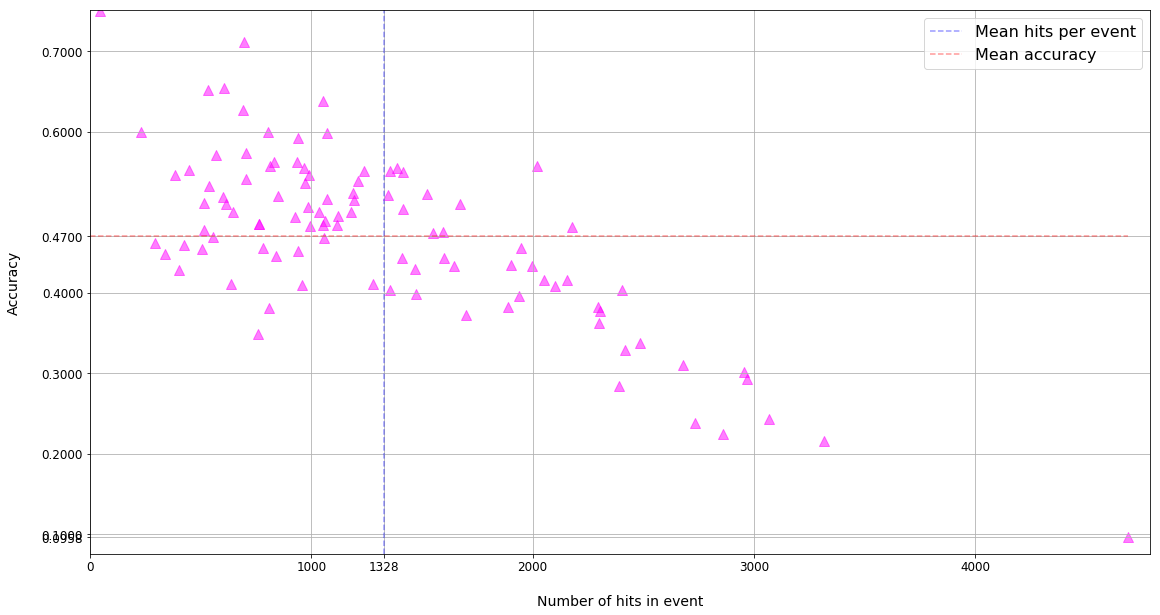

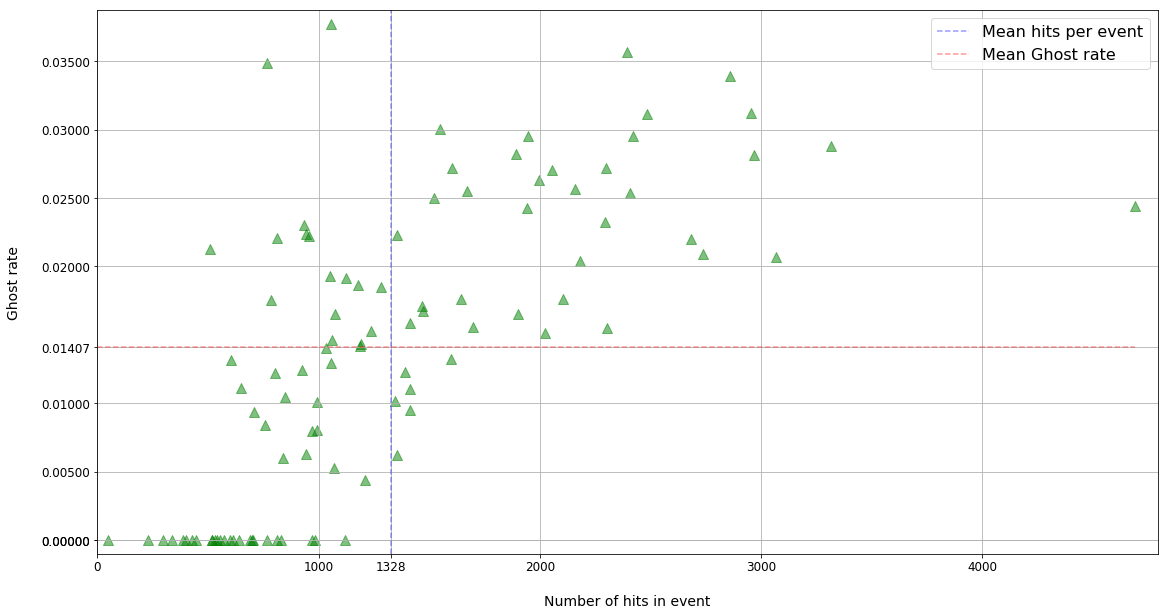

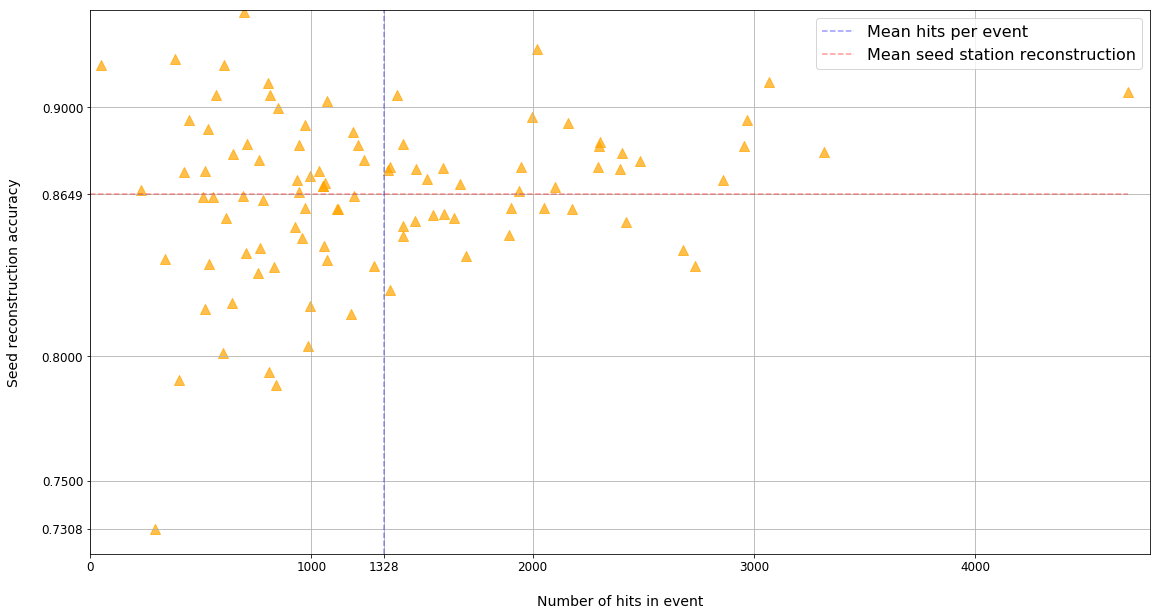

In [102]:
# Normal 100 station reconstruction
values = [0.546512, 0.500000, 0.504065, 0.524272, 0.481481, 0.627119, 0.500000, 0.474820, 0.592593, 0.483516, 0.448276, 0.484848, 0.410714, 0.478261, 0.520548, 0.600000, 0.597826, 0.337963, 0.511111, 0.381818, 0.454545, 0.215278, 0.500000, 0.467391, 0.348485, 0.095823, 0.493827, 0.361809, 0.519231, 0.403846, 0.415730, 0.637363, 0.484848, 0.509434, 0.571429, 0.433735, 0.550847, 0.573770, 0.445946, 0.554217, 0.371622, 0.310638, 0.433566, 0.535714, 0.557471, 0.459459, 0.474074, 0.237500, 0.455621, 0.224000, 0.484536, 0.395210, 0.516129, 0.653846, 0.489130, 0.652174, 0.292969, 0.494845, 0.455882, 0.380282, 0.538462, 0.429688, 0.505882, 0.381910, 0.540984, 0.461538, 0.522727, 0.562500, 0.510345, 0.416216, 0.552632, 0.300781, 0.443548, 0.407609, 0.482759, 0.403361, 0.551402, 0.442857, 0.283654, 0.328571, 0.545455, 0.433526, 0.469388, 0.600000, 0.410714, 0.428571, 0.514563, 0.243346, 0.554622, 0.409639, 0.451220, 0.398438, 0.557143, 0.711864, 0.549180, 0.750000, 0.531915, 0.376884, 0.521368, 0.561644]
showPlotAccuracy(values)
values = [0.008065, 0.014035, 0.011013, 0.014184, 0.020408, 0.000000, 0.011111, 0.013216, 0.006289, 0.019293, 0.000000, 0.000000, 0.000000, 0.000000, 0.010417, 0.012195, 0.016484, 0.031122, 0.000000, 0.028183, 0.021277, 0.028811, 0.018605, 0.037736, 0.008403, 0.024401, 0.012422, 0.027201, 0.000000, 0.025335, 0.027027, 0.012903, 0.034884, 0.000000, 0.000000, 0.016505, 0.006231, 0.009346, 0.006024, 0.000000, 0.015590, 0.022028, 0.017575, 0.007937, 0.015099, 0.000000, 0.030055, 0.020891, 0.029505, 0.033912, 0.000000, 0.024289, 0.005291, 0.013158, 0.014634, 0.000000, 0.028124, 0.019139, 0.017544, 0.000000, 0.004405, 0.017094, 0.000000, 0.023268, 0.000000, 0.000000, 0.025000, 0.022989, 0.025526, 0.025641, 0.000000, 0.031241, 0.009479, 0.017608, 0.010101, 0.022284, 0.015267, 0.027197, 0.035657, 0.029492, 0.000000, 0.026279, 0.000000, 0.000000, 0.018476, 0.000000, 0.014354, 0.020650, 0.012285, 0.022222, 0.022388, 0.016731, 0.022059, 0.000000, 0.015873, 0.000000, 0.000000, 0.015473, 0.010169, 0.000000]
showGhostRate(values)
values = [0.872093, 0.874074, 0.848238, 0.889968, 0.858907, 0.864407, 0.880952, 0.875300, 0.884774, 0.868132, 0.839080, 0.843434, 0.821429, 0.818841, 0.899543, 0.909524, 0.902174, 0.878086, 0.874074, 0.848485, 0.863636, 0.881944, 0.816993, 0.844203, 0.833333, 0.905815, 0.851852, 0.884422, 0.801282, 0.881410, 0.859551, 0.868132, 0.878788, 0.855346, 0.904762, 0.859438, 0.875706, 0.885246, 0.788288, 0.859438, 0.840090, 0.842553, 0.855478, 0.892857, 0.923372, 0.873874, 0.856790, 0.836111, 0.875740, 0.870667, 0.859107, 0.866267, 0.838710, 0.916667, 0.869565, 0.891304, 0.894531, 0.859107, 0.862745, 0.793427, 0.884615, 0.854167, 0.803922, 0.876047, 0.841530, 0.730769, 0.871212, 0.870833, 0.868966, 0.893694, 0.894737, 0.884115, 0.852151, 0.867754, 0.819923, 0.826331, 0.878505, 0.857143, 0.875000, 0.853968, 0.919192, 0.895954, 0.863946, 0.866667, 0.836310, 0.790476, 0.864078, 0.910013, 0.904762, 0.847390, 0.865854, 0.875000, 0.904762, 0.937853, 0.885246, 0.916667, 0.836879, 0.886097, 0.874644, 0.835616]
showStationAccuracy(values)

In [ ]:
# Long 
# Normal 100
values = [0.632653, 0.636364, 0.654545, 0.647059, 0.509434, 0.689655, 0.703704, 0.552632, 0.700000, 0.625000, 0.666667, 0.675676, 0.466667, 0.583333, 0.617021, 0.600000, 0.693878, 0.584158, 0.312500, 0.645570, 0.541667, 0.588235, 0.677966, 0.545455, 0.516129, 0.370044, 0.607843, 0.578947, 0.580645, 0.621849, 0.655914, 0.673469, 0.520000, 0.720000, 0.708333, 0.556818, 0.600000, 0.555556, 0.574468, 0.750000, 0.555556, 0.528455, 0.534091, 0.659574, 0.600000, 0.550000, 0.728571, 0.554455, 0.655172, 0.635659, 0.666667, 0.548387, 0.584906, 0.781250, 0.573770, 0.727273, 0.602837, 0.500000, 0.631579, 0.531250, 0.633333, 0.539683, 0.653846, 0.577320, 0.750000, 0.769231, 0.650000, 0.612245, 0.604651, 0.745763, 0.684211, 0.603896, 0.586207, 0.588235, 0.651163, 0.583333, 0.631579, 0.600000, 0.565217, 0.523364, 0.727273, 0.545455, 0.653846, 0.833333, 0.482143, 0.545455, 0.660714, 0.653846, 0.651163, 0.604651, 0.547619, 0.552239, 0.666667, 0.775000, 0.597015, 0.666667, 0.541667, 0.533333, 0.600000, 0.673469]
showPlotAccuracy(values)
# Ghost
values = [0.000000, 0.000000, 0.014493, 0.000000, 0.019048, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.029412, 0.005525, 0.000000, 0.005435, 0.037037, 0.014572, 0.013889, 0.027397, 0.000000, 0.032912, 0.016667, 0.013699, 0.000000, 0.014599, 0.009950, 0.012346, 0.000000, 0.000000, 0.000000, 0.006667, 0.010309, 0.016129, 0.000000, 0.000000, 0.013245, 0.005076, 0.012658, 0.000000, 0.010471, 0.000000, 0.008850, 0.015209, 0.006410, 0.020642, 0.000000, 0.027972, 0.000000, 0.000000, 0.000000, 0.000000, 0.016779, 0.037037, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.012195, 0.000000, 0.000000, 0.012121, 0.014706, 0.037736, 0.000000, 0.000000, 0.014948, 0.000000, 0.006329, 0.000000, 0.000000, 0.000000, 0.019868, 0.019337, 0.023256, 0.000000, 0.020460, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.008955, 0.000000, 0.000000, 0.016129, 0.000000, 0.000000, 0.000000, 0.026087, 0.000000, 0.000000, 0.017906, 0.000000, 0.000000]
showGhostRate(values)
# Station reconstruction
values = [0.877551, 0.915152, 0.909091, 0.895425, 0.867925, 0.885057, 0.938272, 0.872807, 0.913333, 0.900000, 0.911111, 0.900901, 0.855556, 0.916667, 0.907801, 0.933333, 0.931973, 0.924092, 0.770833, 0.881857, 0.930556, 0.894608, 0.903955, 0.872727, 0.903226, 0.919236, 0.888889, 0.894737, 0.817204, 0.924370, 0.885305, 0.911565, 0.840000, 0.880000, 0.930556, 0.859848, 0.907692, 0.874074, 0.858156, 0.944444, 0.888889, 0.880759, 0.882576, 0.921986, 0.914815, 0.900000, 0.923810, 0.904290, 0.908046, 0.906977, 0.923077, 0.899642, 0.861635, 0.927083, 0.907104, 0.919192, 0.919622, 0.876543, 0.894737, 0.843750, 0.927778, 0.888889, 0.903846, 0.896907, 0.944444, 0.897436, 0.891667, 0.850340, 0.930233, 0.926554, 0.947368, 0.887446, 0.902299, 0.911765, 0.844961, 0.844444, 0.900585, 0.921569, 0.915942, 0.884735, 0.909091, 0.890909, 0.923077, 1.000000, 0.857143, 0.833333, 0.886905, 0.939103, 0.910853, 0.875969, 0.904762, 0.865672, 0.902778, 0.958333, 0.910448, 0.888889, 0.861111, 0.913889, 0.888889, 0.918367]
showStationAccuracy(values)

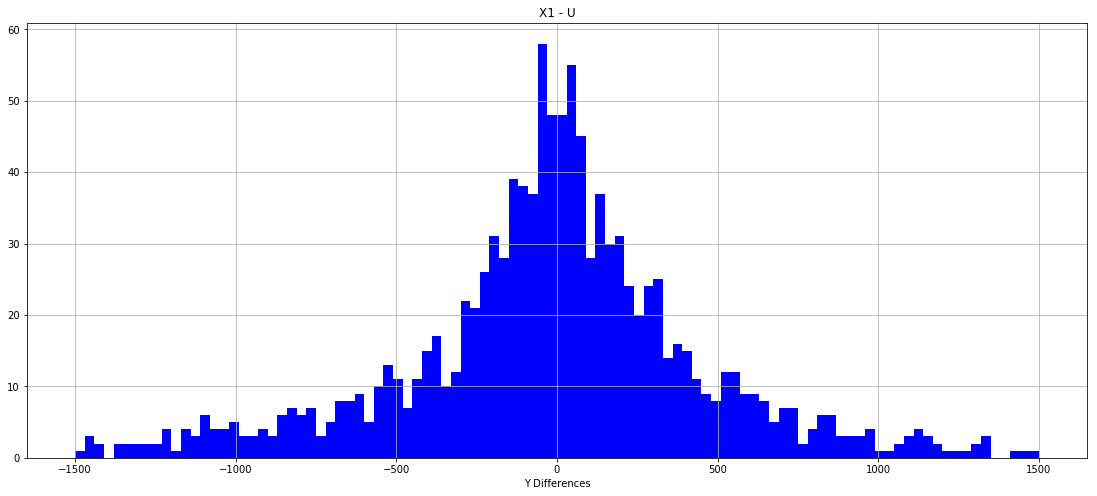

Mean -11.304472 
Variance 531.003003 


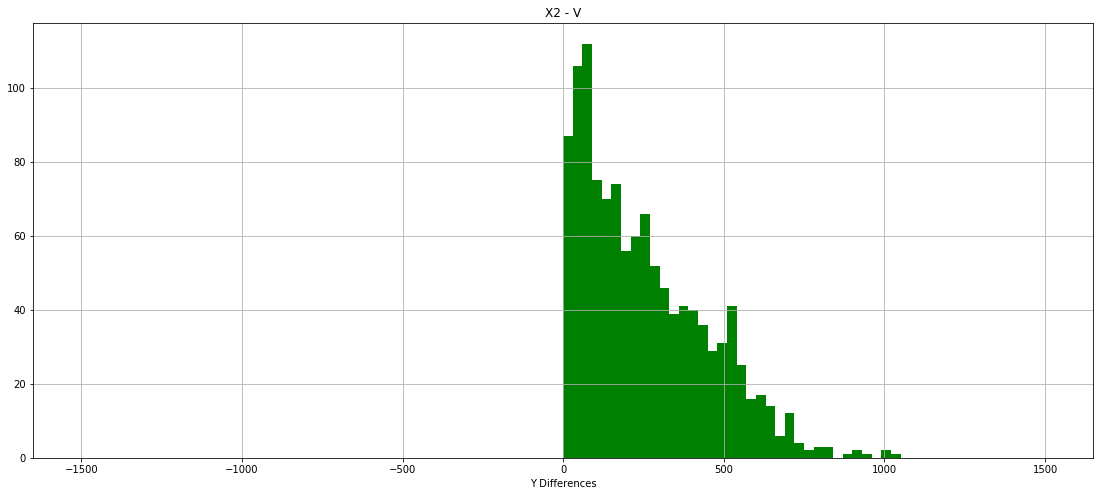

Mean 253.465348 
Variance 195.679683 


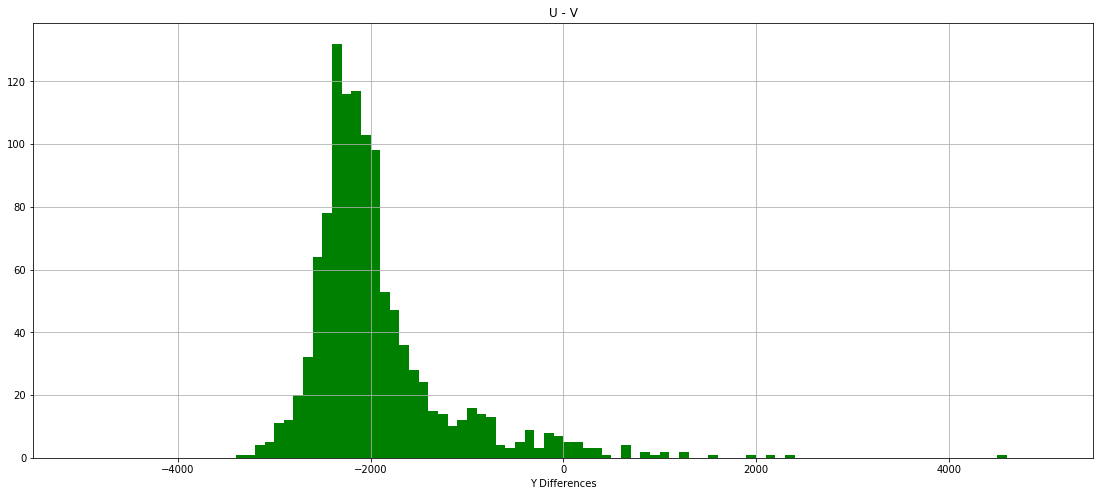

Mean -1643.017318 
Variance 2343.381940 


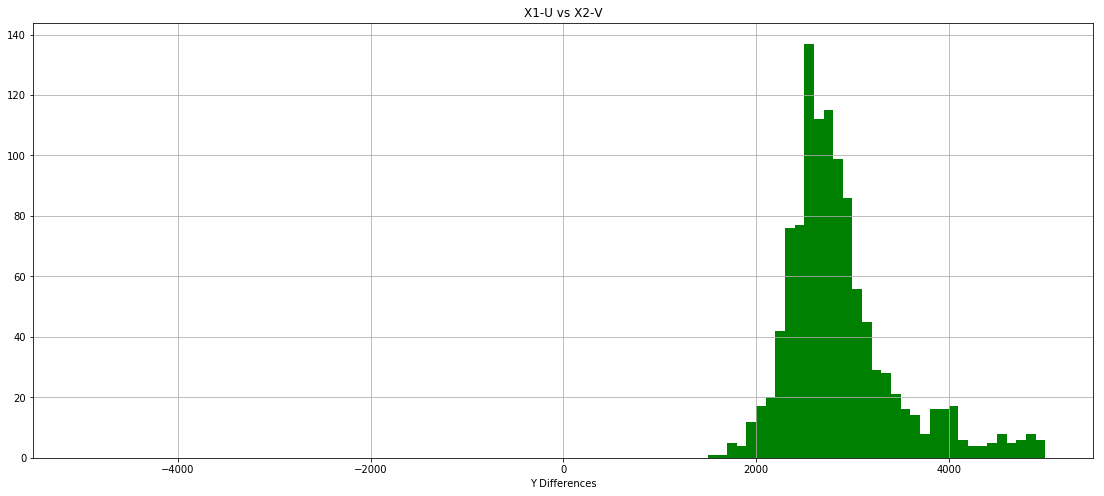

Mean 3234.283951 
Variance 2343.381940 


In [13]:
X_plot_X1_U = []
X_plot_X2_V = []
X_plot_U_V = []
unified_plot = []
pos = 0
event_hits = mc_hits[mc_hits[:,13] < events[10]]
acot = 11.4300526450039

for hit in event_hits:
    
    if (len(hit[5]) > 0):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
                
        if (X_final[0] == 0) or len(hit[1]) < 12:
            continue
        
        X_plot_X1_U.append(hit[2][0])
        X_plot_X2_V.append(np.abs(hit[1][0] - hit[1][1]) * acot)
        X_plot_U_V.append( hit[2][0] - (max_y - np.abs(X_final[0] - X_final[1]) * acot))
        unified_plot.append( hit[2][0] - (min_y - np.abs(X_final[0] - X_final[1])*acot))
        
        pos += 1
        
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_X1_U, 100, facecolor='blue', range=(-1500,1500))
ax.set_xlabel('Y Differences')
ax.set_title('X1 - U')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X_plot_X1_U)))
print("Variance %f " % np.std(np.array(X_plot_X1_U)))

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_X2_V, 100, facecolor='green', range=(-1500,1500))
ax.set_xlabel('Y Differences')
ax.set_title('X2 - V')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X_plot_X2_V)))
print("Variance %f " % np.std(np.array(X_plot_X2_V)))


fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_U_V, 100, facecolor='green',range=(-5000,5000))
ax.set_xlabel('Y Differences')
ax.set_title('U - V')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X_plot_U_V)))
print("Variance %f " % np.std(np.array(X_plot_U_V)))


fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(unified_plot, 100, facecolor='green',range=(-5000,5000))
ax.set_xlabel('Y Differences')
ax.set_title('X1-U vs X2-V')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(unified_plot)))
print("Variance %f " % np.std(np.array(unified_plot)))

In [18]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
    
    if (x3 - x0 == 0):
        m = 1
    else:
        m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [14]:
def histogram(data, color, min, max, title, x_axis, y_axis):
    fig = plt.figure(figsize=(19, 10))
    ax = fig.add_subplot(111)
    
    textstr = '$\mu=%.3f$\n$\sigma=%.3f$\n$n=%.0f$'%(np.mean(np.array(data)), np.std(np.array(data)), len(data))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)

    n, bins, patches = plt.hist(data, 100, facecolor=color, range=(min,max))
    ax.set_title('%s\n' % title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.grid()
    plt.show()

359.2349853516 348.7349853516 548.967956543 9 8 11
-2177.8100585938 0.0 -2066.0632324219 9 8 11
1401.9924801596826


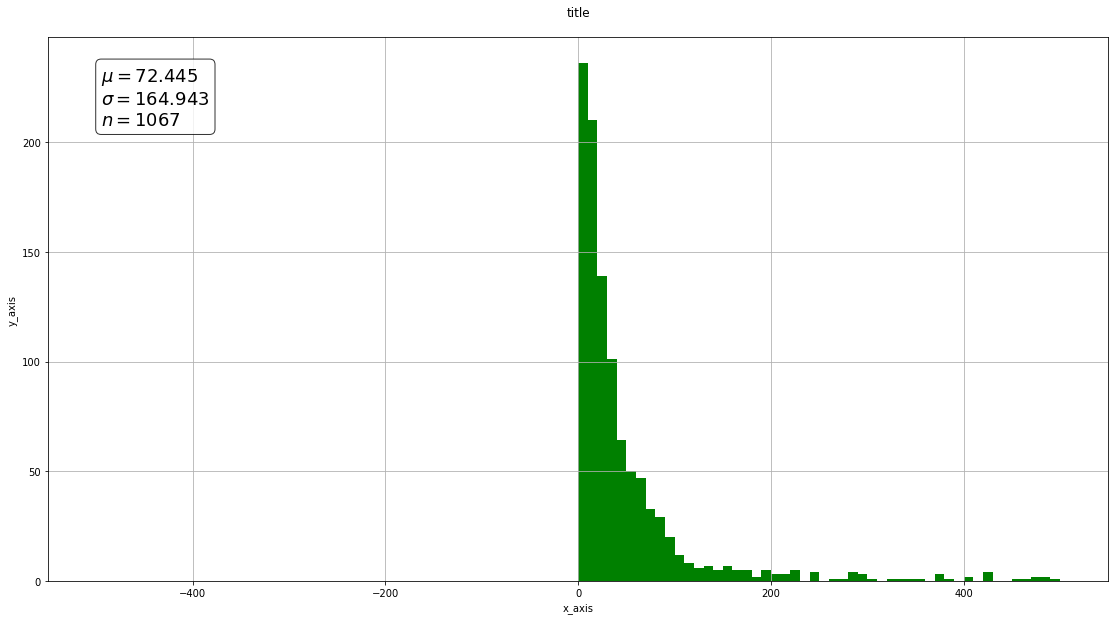

In [30]:
X_plot = []
pos = 0

event_hits = mc_hits[mc_hits[:,13] < events[10]]

for hit in event_hits:
    
    if (len(hit[5]) > 0):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
                
        if (X_final[0] == 0) or (X_final[1] == 0) or (X_final[2] == 0) or (X_final[3] == 0) or (X_final[4] == 0) or (X_final[5] == 0) or (X_final[6] == 0) or (X_final[7] == 0):
            continue
        
        first = predictHeight(X_final[0], X_final[3], X_final[1], 1, 0, 3)
        if first > 0 and first > max_y or first < 0 and first < min_y:
            print(X_final[8], X_final[11], X_final[9], 9, 8, 11)
            continue
        second = predictHeight(X_final[4], X_final[7], X_final[5], 5, 4, 7)
        if second > 0 and second > max_y or second < 0 and second < min_y:
            print(X_final[4], X_final[7], X_final[5], 5, 4, 7)
            continue
        X_plot.append(np.abs(second - first))

print(np.max(X_plot))
histogram(X_plot, 'green', -500, 500, 'title', 'x_axis', 'y_axis')

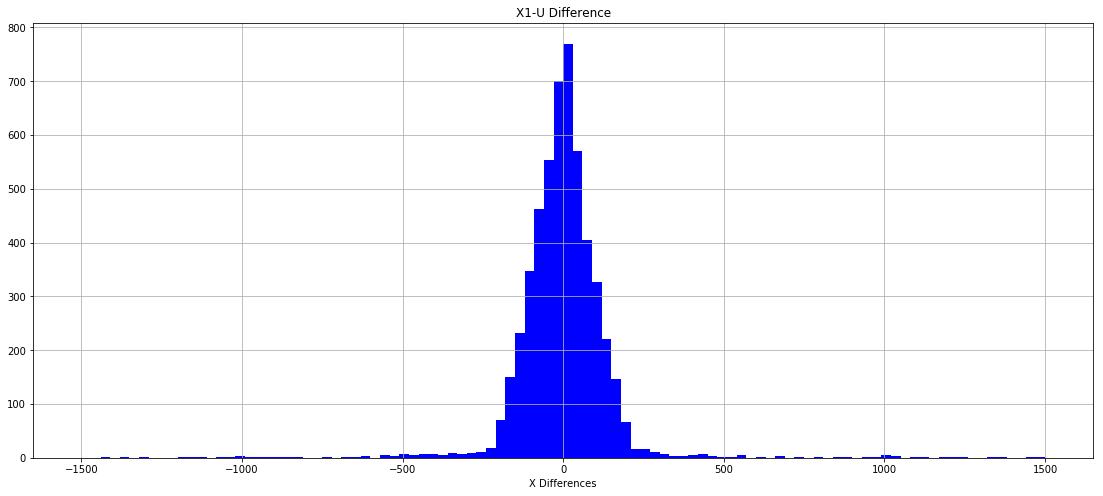

Mean 2.286665 
Variance 201.420861 


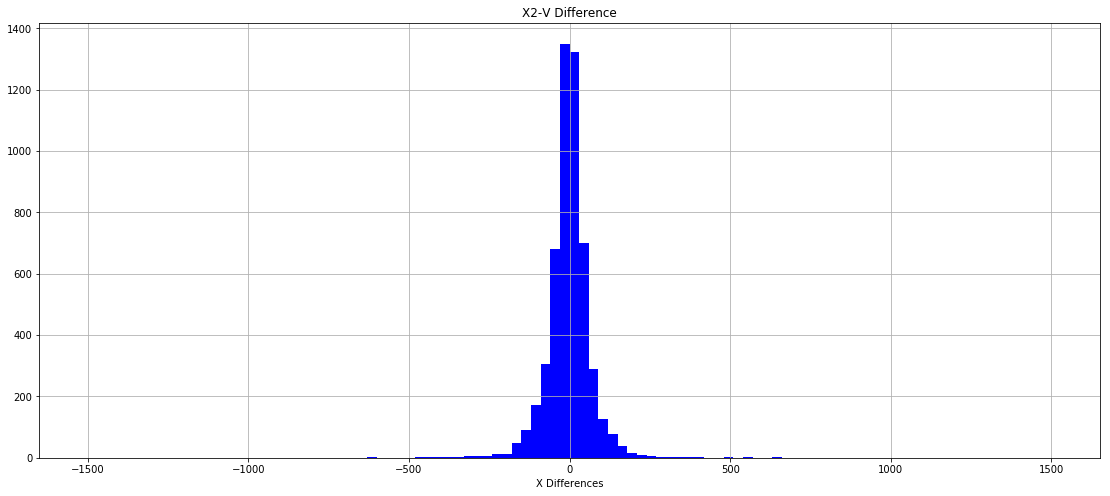

Mean -1.554239 
Variance 82.585660 


In [19]:
UV_diff = []
X1U_diff = []
X2V_diff = []

pos = 0

event_hits = mc_hits[mc_hits[:,13] < events[40]]

for hit in event_hits:
    
    if (len(hit[5]) > 0):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
                
        if (X_final[1] != 0) and (X_final[1] != 0):
            X1U_diff.append(X_final[0] - X_final[3])
        if (X_final[2] != 0) and (X_final[3] != 0):
            X2V_diff.append(X_final[2] - X_final[3])
        if (X_final[1] != 0) and (X_final[2] != 0):
            UV_diff.append(X_final[1] - X_final[2])
    

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X1U_diff, 100, facecolor='blue', range=(-1500,1500))
ax.set_xlabel('X Differences')
ax.set_title('X1-U Difference')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X1U_diff)))
print("Variance %f " % np.std(np.array(X1U_diff)))


fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X2V_diff, 100, facecolor='blue', range=(-1500,1500))
ax.set_xlabel('X Differences')
ax.set_title('X2-V Difference')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X2V_diff)))
print("Variance %f " % np.std(np.array(X2V_diff)))

In [48]:
max_y

2438.6506347656

In [10]:
def histogram(data, color, min, max, title, x_axis, y_axis):
    fig = plt.figure(figsize=(19, 10))
    ax = fig.add_subplot(111)
    
    textstr = '$\mu=%.3f$\n$\sigma=%.3f$\n$n=%.0f$'%(np.mean(np.array(data)), np.std(np.array(data)), len(data))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)

    n, bins, patches = plt.hist(data, 100, facecolor=color, range=(min,max))
    ax.set_title('%s\n' % title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.grid()
    plt.show()

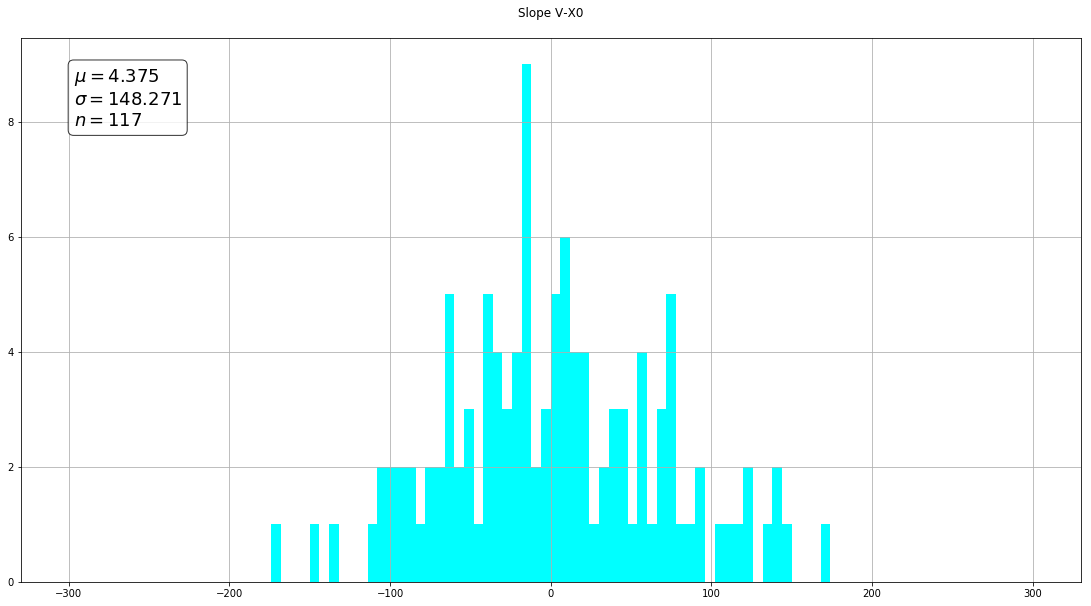

In [11]:
X_plot = []
Y_plot = []

zInf = 1 / (zLays[2] - zLays[0])

event_hits = mc_hits[mc_hits[:,13] < events[1]]
# For each particle of a given event
for particle in event_hits:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
        
        m = float(zLays[0]) / float(X_final[0])
        n = zLays[0] - (m * X_final[0])
        pred = (zLays[3] - n) / m

        Y_plot.append(pred - X_final[3])
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

histogram(Y_plot, 'cyan', -300, 300, 'Slope V-X0', '', '')

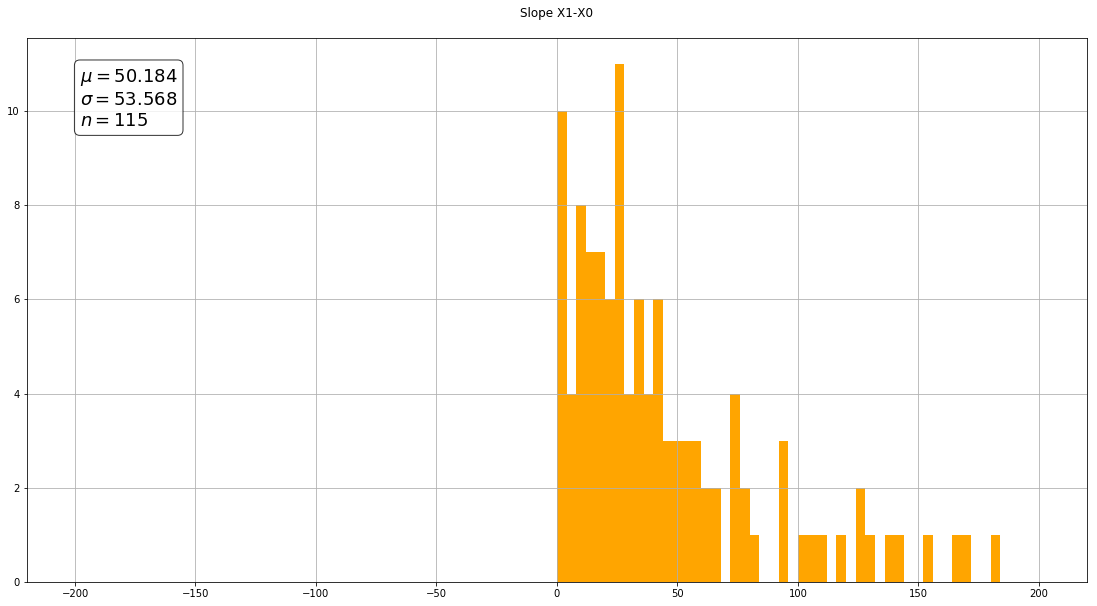

In [16]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model.h5')

X_plot = []
Y_plot = []

event_hits = mc_hits[mc_hits[:,13] < events[1]]

# For each particle of a given event
for particle in event_hits:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
                
        if (X_final[3] == 0):
            continue
                
        predicted = (xlayer_model.predict(np.array([X_final[0], 0]).reshape(1,-1)))[0]
        
        Y_plot.append(np.abs(predicted[2] - X_final[3]))
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

histogram(Y_plot, 'orange', -200, 200, 'Slope X1-X0', '', '')